In [ ]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
!unzip -qo Parkinson_disease_detection.zip

--2023-04-22 04:45:25--  https://cainvas-static.s3.amazonaws.com/media/user_data/Yuvnish17/Parkinson_disease_detection.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.158.175
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.158.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8201907 (7.8M) [application/x-zip-compressed]
Saving to: ‘Parkinson_disease_detection.zip’

Parkinson_disease_d 100%[===================>]   7.82M  14.1MB/s    in 0.6s    

2023-04-22 04:45:26 (14.1 MB/s) - ‘Parkinson_disease_detection.zip’ saved [8201907/8201907]



In [ ]:
data_train = np.load('Parkinson_disease_detection/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

print(x_train.shape)
print(y_train.shape)

(72, 256, 256, 3)
(72,)


In [ ]:
data_test = np.load('Parkinson_disease_detection/test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

print(x_test.shape)
print(y_test.shape)
(30, 256, 256, 3)

(30, 256, 256, 3)
(30,)


(30, 256, 256, 3)

In [ ]:
train_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=360,
                                    width_shift_range=0.0,
                                    height_shift_range=0.0,
#                                     brightness_range=[0.5, 1.5],
                                    horizontal_flip=True,
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

5040
5040
5112
5112
600
600
630
630


In [ ]:
for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train[i] = img

for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_test[i] = img

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train/255.0
x_test = x_test/255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5112, 128, 128, 1)
(5112, 2)
(630, 128, 128, 1)
(630, 2)


In [ ]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu',
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))

    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') is not None and logs.get('acc') > ACCURACY_THRESHOLD):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
          self.model.stop_training = True

In [ ]:
callbacks = myCallback()
ACCURACY_THRESHOLD = 0.95

In [ ]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),callbacks=[callbacks])

Epoch 1/100
 6/40 [===>..........................] - ETA: 3s - loss: 0.8558 - accuracy: 0.5260

40/40 [==============================] - 24s 187ms/step - loss: 0.8547 - accuracy: 0.5063 - val_loss: 0.8480 - val_accuracy: 0.5000
Epoch 2/100
40/40 [==============================] - 5s 118ms/step - loss: 0.8453 - accuracy: 0.4967 - val_loss: 0.8416 - val_accuracy: 0.5000
Epoch 3/100
40/40 [==============================] - 5s 120ms/step - loss: 0.8387 - accuracy: 0.5090 - val_loss: 0.8357 - val_accuracy: 0.5000
Epoch 4/100
40/40 [==============================] - 5s 114ms/step - loss: 0.8333 - accuracy: 0.4963 - val_loss: 0.8301 - val_accuracy: 0.5000
Epoch 5/100
40/40 [==============================] - 5s 119ms/step - loss: 0.8273 - accuracy: 0.5033 - val_loss: 0.8238 - val_accuracy: 0.5000
Epoch 6/100
40/40 [==============================] - 5s 117ms/step - loss: 0.8222 - accuracy: 0.5012 - val_loss: 0.8185 - val_accuracy: 0.5000
Epoch 7/100
40/40 [==============================] - 5s 119ms/step - loss: 0.8176 - accuracy: 0.5041 - val_loss: 0.8142 - val_accuracy: 0.6397
Epoch 8/10

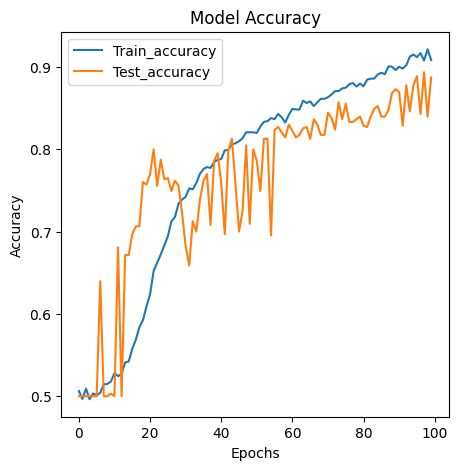

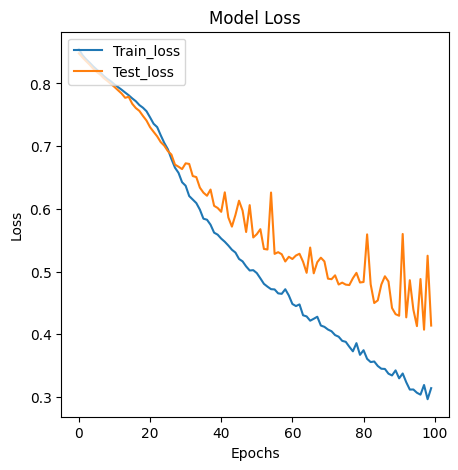

In [ ]:
figure = plt.figure(figsize=(5, 5))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(5, 5))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [ ]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

20/20 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       315
           1       0.85      0.93      0.89       315

    accuracy                           0.89       630
   macro avg       0.89      0.89      0.89       630
weighted avg       0.89      0.89      0.89       630



<Axes: >

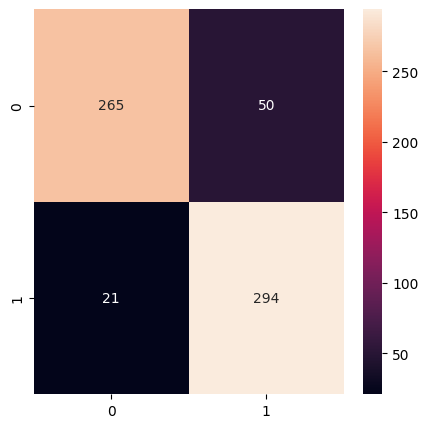

In [ ]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')

In [ ]:
model.save('/content/drive/MyDrive/Park/parkinson_detection.h5')

In [ ]:
m = tf.keras.models.load_model('/content/drive/MyDrive/Park/parkinson_detection.h5')
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [ ]:
labels = ['Healthy', 'Parkinson']
image_healthy = cv2.imread('Parkinson_disease_detection/test_image_healthy.png')
image_parkinson = cv2.imread('Parkinson_disease_detection/test_image_parkinson.png')

image_healthy = cv2.resize(image_healthy, (128, 128))
image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
image_healthy = np.array(image_healthy)
image_healthy = np.expand_dims(image_healthy, axis=0)
image_healthy = np.expand_dims(image_healthy, axis=-1)

image_parkinson = cv2.resize(image_parkinson, (128, 128))
image_parkinson = cv2.cvtColor(image_parkinson, cv2.COLOR_BGR2GRAY)
image_parkinson = np.array(image_parkinson)
image_parkinson = np.expand_dims(image_parkinson, axis=0)
image_parkinson = np.expand_dims(image_parkinson, axis=-1)

In [ ]:
ypred_healthy = m.predict(image_healthy)
print(ypred_healthy)
type(ypred_healthy)
ypred_parkinson = model.predict(image_parkinson)


1/1 [==============================] - 0s 254ms/step
[[1. 0.]]
1/1 [==============================] - 0s 99ms/step


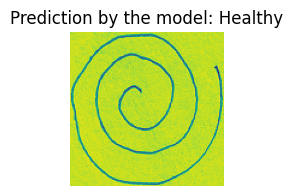

In [ ]:
figure = plt.figure(figsize=(2, 2))
img_healthy = np.squeeze(image_healthy, axis=0)
plt.imshow(img_healthy)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_healthy[0], axis=0)]}')
plt.show()

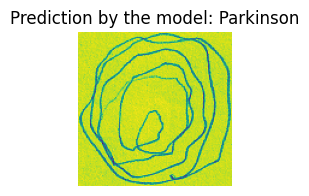

In [ ]:
figure = plt.figure(figsize=(2, 2))
image_parkinson = np.squeeze(image_parkinson, axis=0)
plt.imshow(image_parkinson)
plt.axis('off')
plt.title(f'Prediction by the model: {labels[np.argmax(ypred_parkinson[0], axis=0)]}')
plt.show()

In [ ]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 

In [ ]:
import gradio as gr
image_input = gr.inputs.Image()

label_output = gr.outputs.Label(num_top_classes=1)

def classify(image_healthy):
  image_healthy = cv2.resize(image_healthy, (128, 128))
  image_healthy = cv2.cvtColor(image_healthy, cv2.COLOR_BGR2GRAY)
  image_healthy = np.array(image_healthy)
  image_healthy = np.expand_dims(image_healthy, axis=0)
  image_healthy = np.expand_dims(image_healthy, axis=-1)
  res = model.predict(image_healthy)
  l = labels[np.argmax(res[0], axis=0)]
  return l


gr.Interface(fn=classify, inputs=[image_input], outputs=label_output, title='Image Classification',
             description='Classify an image with threshold using my model').launch(share=True)


/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://bc56441313d131b206.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
